 ## Section 1 Database & Python ETL

### Design and Summary

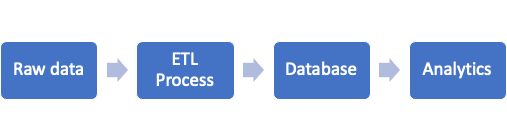

### 1. Raw data
Load the csv file

### 2. ETL Process and Database
- 2.1 Build database using SQLAlchemy
- 2.2 Read the csv file with transformation - Adding country column based on the ip address. 
- 2.3 load csv to database - SQLite.

### 3. Analytics
- Gather requirement, build SQL query based on the business need. 
- Recommend to perform data cleaning, deduplicate before data load.

### 1 Raw data - Import packages and data

In [1]:
!pip install geoip2

Looking in indexes: https://pypi.org/simple/, https://packages.physiq.zone/nexus/repository/pypi-internal/simple, https://packages.physiq.zone/nexus/repository/pypi-research/simple, https://packages.physiq.zone/nexus/repository/pypi-releases/simple, https://packages.physiq.zone/nexus/repository/pypi-playground/simple


In [2]:
import pandas as pd
person = pd.read_csv('DATA.csv')

### 2. ETL process 

### 2.1 Create database Schema

In [12]:
from sqlalchemy import Integer, Column, create_engine, ForeignKey, String, Date, Numeric
from sqlalchemy.orm import relationship, joinedload, subqueryload, Session
from sqlalchemy.ext.declarative import declarative_base

engine = create_engine('sqlite:///SFL.db', echo = False)
Base = declarative_base(engine)

class Person(Base):
    __tablename__ = 'person'
    id = Column(String, primary_key=True)
    first_name = Column(String)
    last_name = Column(String)
    email = Column(String)
    gender = Column(String)
    ip_address = Column(String)
    country = Column(String)
    

Base.metadata.create_all(engine)

### 2.2 Read Data and then do transformation

In [13]:
import geoip2.database
with geoip2.database.Reader('./GeoLite2-City.mmdb') as reader:
    def get_mm(ip):
        try:
            return reader.city(ip)
        except:
            return None
    person['maxmind'] = person.ip_address.apply(get_mm)

In [14]:
### Adding Country 
person['country'] = person.maxmind.apply(lambda it: it.country.name if it else None)

In [15]:
person.head()

,id,first_name,last_name,email,gender,ip_address,maxmind,country
0,1,Margaretta,Laughtisse,mlaughtisse0@mediafire.com,Genderfluid,34.148.232.131,geoip2.models.City({'city': {'geoname_id': 458...,United States
1,2,Vally,Garment,vgarment1@wisc.edu,Bigender,15.158.123.36,geoip2.models.City({'continent': {'code': 'NA'...,United States
2,3,Tessa,Curee,tcuree2@php.net,Bigender,132.209.143.225,geoip2.models.City({'continent': {'code': 'NA'...,Canada
3,4,Arman,Heineking,aheineking3@tuttocitta.it,Male,157.110.61.233,geoip2.models.City({'continent': {'code': 'AS'...,Japan
4,5,Roselia,Trustie,rtrustie4@ft.com,Non-binary,49.55.218.81,geoip2.models.City({'continent': {'code': 'AS'...,China


### 2.3 Load data into database

In [16]:
### Create Session 
sess = Session(engine)

for rowidx, record in person.iterrows():
    print(rowidx)
    print(record)
    c = Person(
        id=record['id'],
        first_name=record['first_name'],
        last_name=record['last_name'],
        email=record['email'],
        gender=record['gender'],
        ip_address=record['ip_address'],
        country=record['country']
    )
    sess.add(c)
sess.commit()

0
id                                                            1
first_name                                           Margaretta
last_name                                            Laughtisse
email                                mlaughtisse0@mediafire.com
gender                                              Genderfluid
ip_address                                       34.148.232.131
maxmind       geoip2.models.City({'city': {'geoname_id': 458...
country                                           United States
Name: 0, dtype: object
1
id                                                            2
first_name                                                Vally
last_name                                               Garment
email                                        vgarment1@wisc.edu
gender                                                 Bigender
ip_address                                        15.158.123.36
maxmind       geoip2.models.City({'continent': {'code': 'NA'...
country      

### 3. Analytics 

The sample query present how many people in different countries. 

In [22]:
sample_query = """
SELECT country, count(*) as country_counts
FROM person
group by country
order by country
"""
sample_df = pd.read_sql(sample_query, engine)

In [20]:
sample_df

,country,country_counts
0,None,151
1,Algeria,3
2,Argentina,2
3,Armenia,1
4,Australia,18
...,...,...
67,Ukraine,5
68,United Kingdom,26
69,United States,332
70,Vietnam,4
